In [1]:
import os
os.chdir('/home/gptrapletti/ds/aerial-multiclass-segm')

import segmentation_models_pytorch as smp
import pytorch_lightning as pl
import torchmetrics
import yaml
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import albumentations as A
import random

from src.datamodule import AerialDataModule

with open('config.yaml') as f:
    cfg = yaml.safe_load(f)

/home/gptrapletti/ds/.miniconda/envs/aerial/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FileNotFoundError: [Errno 2] No such file or directory: 'config.yaml'

# <ins> DATAMODULE

In [ ]:
dm = AerialDataModule(
    data_path=cfg['data_path'], 
    split_path=cfg['split_path'],
    n_random_patches_per_image=cfg['n_random_patches_per_image'],
    patch_size=cfg['patch_size'],
    overlap = 0,
    train_batch_size=cfg['train_batch_size'],
    val_batch_size=cfg['val_batch_size'],
    num_workers=cfg['num_workers'],
    
)
dm.prepare_data()
dm.setup('fit')
dl = dm.train_dataloader()

In [ ]:
batch = next(iter(dl))
images, masks = batch
images.shape, masks.dtype

(torch.Size([32, 3, 256, 256]), torch.float32)

In [ ]:
preds = torch.rand(size=masks.shape)
preds.shape

torch.Size([32, 6, 256, 256])

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn(input=preds, target=masks.type(torch.float32))

tensor(1.8266)

In [ ]:
metric = torchmetrics.Dice(num_classes=6)

In [ ]:
def from_one_hot_to_indexes (masks):
    index_masks = torch.zeros(masks.shape[0], 1, masks.shape[2], masks.shape[3])
    for idx, mask in enumerate(masks):
        for label, channel in enumerate(mask):
            index_masks[idx] += channel * label
            
    return index_masks.type(torch.uint8)    
    

In [ ]:
masks_index = from_one_hot_to_indexes(masks)
masks_index.shape, masks_index.dtype

(torch.Size([32, 1, 256, 256]), torch.uint8)

In [ ]:
metric(preds, masks_index.type(torch.int8))

tensor(0.1665)

In [ ]:
metric(preds=masks.type(torch.float32), target=masks_index)

tensor(1.)

# <ins> MODEL

## BACKBONE

In [ ]:
model = smp.Unet(
    encoder_name = 'resnet34',
    encoder_depth = 5,
    encoder_weights = 'imagenet', # None,
    decoder_use_batchnorm = True,
    decoder_channels = [256, 128, 64, 32, 16],
    decoder_attention_type = None,
    in_channels = 3,
    classes = 6,
    activation = 'softmax'
)

<!-- logger = pl.loggers.MLFlowLogger(
    experiment_name = cfg['experiment_name'],
    run_name = cfg['run_name'],
) -->

In [ ]:
image_filepaths = sorted([os.path.join('data/images', filename) for filename in os.listdir(os.path.join('data/images'))])

len(image_filepaths)

400

In [ ]:
image = cv2.imread(image_filepaths[100])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_NEAREST)

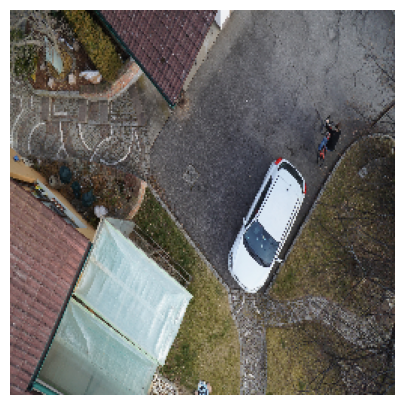

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
image_t = torch.tensor(image).permute(2, 0, 1)[None, ...]
image_t = image_t / 255
image_t = image_t.type(torch.float32)

image_t.shape

torch.Size([1, 3, 256, 256])

In [ ]:
output_t = model(image_t)
output_t.shape

/home/gptrapletti/ds/.miniconda/envs/gym/lib/python3.9/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


torch.Size([1, 6, 256, 256])

In [ ]:
output = output_t.detach().numpy()[0]
output.shape

(6, 256, 256)

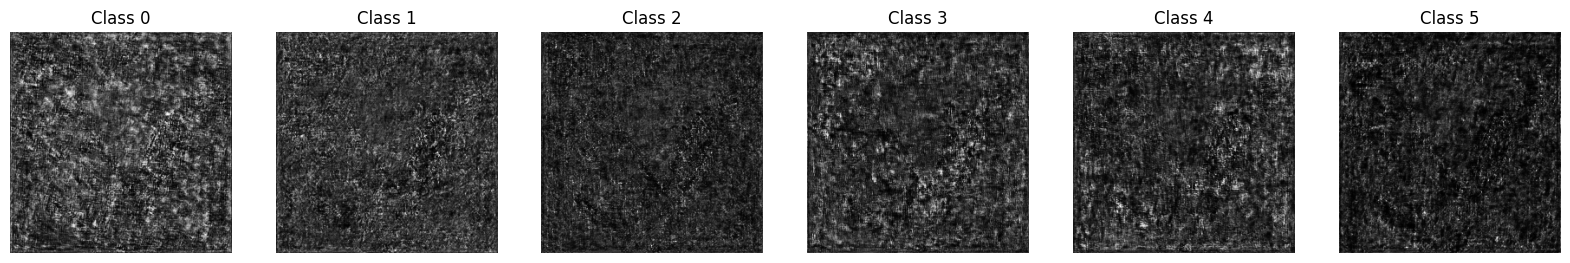

In [ ]:
fig, axs = plt.subplots(1, output.shape[0], figsize=(20, 8))
for i in range(output.shape[0]):
    axs[i].imshow(output[i, ...], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'Class {i}')

## LIGHTNINGMODULE

In [ ]:
from src.module import AerialModule
from src.datamodule import AerialDataModule

In [ ]:
datamodule = AerialDataModule(
    data_path=cfg['data_path'], 
    split_path=cfg['split_path'],
    n_random_patches_per_image=cfg['n_random_patches_per_image'],
    patch_size=cfg['patch_size'],
    train_batch_size=cfg['train_batch_size'],
    val_batch_size=cfg['val_batch_size'],
    num_workers=cfg['num_workers'],
    overlap=0
)

In [ ]:
backbone = smp.Unet(
    encoder_name = 'resnet34',
    encoder_depth = 5,
    encoder_weights = 'imagenet', # None,
    decoder_use_batchnorm = True,
    decoder_channels = [256, 128, 64, 32, 16],
    decoder_attention_type = None,
    in_channels = 3,
    classes = 6,
    activation = 'softmax'
)

In [ ]:
model = AerialModule(backbone=backbone, lr=0.01)

In [ ]:
trainer = pl.Trainer(max_epochs=10, accelerator='gpu')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/gptrapletti/ds/.miniconda/envs/gym/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(


In [ ]:
trainer.fit(model=model, datamodule=datamodule)

# <ins> LOSSES

## WEIGHTED CROSSENTROPY

In [2]:
# Category frequencies
freq = {
    '0' : 0.0521,
    '1' : 0.4886,
    '2' : 0.3041,
    '3' : 0.1226,
    '4' : 0.0221,
    '5' : 0.0105,
}

In [3]:
# Weights proportional to class frequencies
l = []
for cat in freq:
    weight = np.round(1-freq[cat], 2)
    l.append(weight)
    
print(l)

[0.95, 0.51, 0.7, 0.88, 0.98, 0.99]


In [4]:
image_filepaths = sorted([os.path.join('data/images', filename) for filename in os.listdir(os.path.join('data/images'))])
mask_filepaths = sorted([os.path.join('data/masks', filename) for filename in os.listdir(os.path.join('data/masks'))])

len(image_filepaths), len(mask_filepaths)

(400, 400)

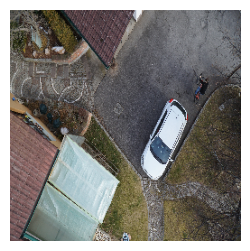

In [5]:
# Image
image = cv2.imread(image_filepaths[100])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_NEAREST)

plt.figure(figsize=(3, 3))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

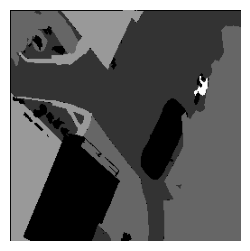

In [6]:
# GT mask
mask = cv2.imread(mask_filepaths[100])
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)[..., 0]

plt.figure(figsize=(3, 3))
plt.imshow(mask*25, cmap='gray')
plt.axis('off')
plt.show()

In [7]:
from src.utils import mask_to_one_hot

In [8]:
# GT mask one-hot encoded
gt_mask_ohe = mask_to_one_hot(mask, n_classes=6)
gt_mask_ohe.shape

(256, 256, 6)

(256, 256, 6)


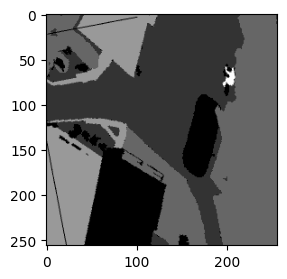

In [9]:
# Distort GT mask to simulate pred mask
# Imagine it made of logits
random.seed(11)
transforms = A.Rotate(limit=90, p=1)
pred_mask = transforms(image=mask)['image']
pred_mask_ohe = mask_to_one_hot(pred_mask, n_classes=6)

print(pred_mask_ohe.shape)

plt.figure(figsize=(3, 3))
plt.imshow(pred_mask*25, cmap='gray')
plt.show()

In [10]:
# To tensors
gt_mask_t = torch.tensor(gt_mask_ohe.transpose(2, 0, 1))
pred_mask_t = torch.tensor(pred_mask_ohe.transpose(2, 0, 1))

# Add batch dimension!!!
gt_mask_t = gt_mask_t[None, ...].type(torch.float32)
pred_mask_t = pred_mask_t[None, ...].type(torch.float32)

gt_mask_t.shape, pred_mask_t.shape, gt_mask_t.dtype, pred_mask_t.dtype

(torch.Size([1, 6, 256, 256]),
 torch.Size([1, 6, 256, 256]),
 torch.float32,
 torch.float32)

In [11]:
# Loss GT vs GT, to test it
# It should be zero but since CE applies a softmax, the pred mask gets changed --> no more perfect match
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn(input=gt_mask_t, target=gt_mask_t)

# 1.0436

tensor(1.0436)

In [12]:
# Loss GT vs Preds
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn(input=pred_mask_t, target=gt_mask_t)

# 1.3217

tensor(1.3217)

In [169]:
# By default, CE loss gives the same weight (1.0) to all classes.
loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor([1, 1, 1, 1, 1, 1]))
loss_fn(input=pred_mask_t, target=gt_mask_t)

tensor(1.3217)

In [170]:
# Add weights as integers [0, +inf] 
# penalizing vegetation and people (to make the model focus on them)
# We expect the loss to be higher than the loss with no weights
loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor([1, 1, 5, 1, 1, 10]))
loss_fn(input=pred_mask_t, target=gt_mask_t)

# 2.9235

tensor(2.9235)

In [ ]:
# Add weights as fractions [0, 1], summing to 1
weights_as_fractions = torch.tensor([1, 1, 5, 1, 1, 10]) / torch.sum(torch.tensor([1, 1, 5, 1, 1, 10]))
print(weights_as_fractions, weights_as_fractions.sum())

loss_fn = torch.nn.CrossEntropyLoss(weight=weights_as_fractions)
loss_fn(input=pred_mask_t, target=gt_mask_t)

# 0.1539
# We expected the loss to be the same as for interger weights, but it's not!

tensor([0.0526, 0.0526, 0.2632, 0.0526, 0.0526, 0.5263]) tensor(1.)


tensor(0.1539)

- Even if interger weights and fraction weights are equivalent, the result is different, because of how the weights are multiplied to the CE formula.
- In a nutshell, when weights are integers, we are multiplying the loss of the different classes by different coeffiecients. When the weights are fractions, we are reducing the loss of each class by different percentages: some classes are reduce more, other less.
- Only numbers change, while the reciprocal relation between classes is the same for integers or fraction weights.
- Remember: the value of the loss means nothing, it is the difference between consecutive losses to matter.
- It is both common practice and advised to use fractional weights.

## CUSTOM WEIGHTED CROSSENTROPY CLASS

In [ ]:
class CustomCrossEntropyLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = torch.nn.Softmax(dim=1)

    def forward(self, input, target):
        input_activated = self.activation(input)
        input_activated = torch.where(input_activated == 0., torch.tensor(1e-8), input_activated)
        pixel_losses = -torch.sum(target * torch.log(input_activated), dim=1) # shape = [H, W]
        batch_loss = torch.mean(pixel_losses)
        return batch_loss

In [ ]:
my_loss_fn = CustomCrossEntropyLoss()
loss = my_loss_fn(input=pred_mask_t, target=gt_mask_t)
loss

# 1.3217

tensor(1.3217)

Test if it works even for a batch with more than one image.

In [ ]:
dummy_pred = torch.randn((4, 6, 256, 256)).type(torch.float32)
dummy_gt = torch.where(dummy_pred > 0.5, 1, 0).type(torch.float32)

In [ ]:
my_loss_fn(input=dummy_pred, target=dummy_gt).mean()

tensor(2.3156)

In [ ]:
# Batch loss computed as the mean on all pixel values is the same as computing the loss 
# for every image separately and then averaging these losses.
losses = []
for i in range(4):
    loss = my_loss_fn(input=dummy_pred[i, ...][None, ...], target=dummy_gt[i, ...][None, ...]).item()
    losses.append(loss)
    
print(losses)
print(np.mean(losses))

[2.3276138305664062, 2.320788860321045, 2.310835838317871, 2.3032968044281006]
2.3156338334083557


In [ ]:
from typing import List, Optional

class CustomWeightedCrossEntropyLoss(torch.nn.Module):
    '''A PyTorch Module for computing weighted cross entropy loss.
    
    Args:
        class_weights: A tensor with class weights.    
    '''
    def __init__(self, class_weights: Optional[torch.Tensor]=None) -> None:
        super().__init__()
        self.activation = torch.nn.Softmax(dim=1)
        self.class_weights = class_weights

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        '''Computes the weighted cross-entropy loss between the input and target.
    
        Args:
            input: A tensor with model logits. Required shape [batch size, n classes, H, W]. 
            target: A tensor with GT one-hot-encoded. Required shape [batch size, n classes, H, W].
                
        Returns:
            torch.Tensor: A scalar tensor representing the computed weighted cross-entropy loss for the input batch,
            as average on all pixel losses.
        
        '''
        input_activated = self.activation(input)
        input_activated = torch.where(input_activated == 0., torch.tensor(1e-8), input_activated)
        pixel_losses = -torch.sum(target * torch.log(input_activated), dim=1) # shape = [H, W]

        if self.class_weights is not None:
            weighted_pixel_losses = target * self.class_weights.view(1, -1, 1, 1) # basically the target tensor with class weights instead of ones.
            weighted_pixel_losses = torch.sum(weighted_pixel_losses, dim=1) # basically the mask [H, W] with class indexes but with the weights.
            pixel_losses = pixel_losses * weighted_pixel_losses # weight every pixel loss.
        
        batch_loss = torch.mean(pixel_losses) # batch loss as average over all pixel losses
        
        return batch_loss

# Usage:
# Initialize class_weights tensor
class_weights = torch.tensor([1, 1, 5, 1, 1, 10]).to(pred_mask_t.device)

# Initialize the CustomCrossEntropyLoss with class_weights
criterion = CustomWeightedCrossEntropyLoss(class_weights=class_weights)

# Compute loss
loss = criterion(input=pred_mask_t, target=gt_mask_t)
print(loss)


tensor(2.9235)


## CUSTOM FOCAL LOSS

In [1]:
# Study on Focal loss

In [13]:
def simple_focal_loss(pred, gt, gamma=2, alpha=1):
    pt = pred if gt == 1 else 1 - pred
    fl = - alpha * ((1 - pt)**gamma) * np.log(pt)
    return fl

In [14]:
print(simple_focal_loss(pred=0.8, gt=1)) # good prediction for class 1 --> low loss
print(simple_focal_loss(pred=0.2, gt=0)) # good prediction for class 0 --> low loss
print(simple_focal_loss(pred=0.2, gt=1)) # bad prediction for class 1 --> high loss
print(simple_focal_loss(pred=0.8, gt=0)) # bad prediction for class 0 --> high loss

0.008925742052568384
0.008925742052568384
1.0300402639578243
1.0300402639578246


In [34]:
# Multiclass
# torch.manual_seed(57)
pred_logits = torch.randn(size=[5, ])
pred_soft = torch.nn.Softmax(dim=0)(pred_logits)

gt = (torch.randn(size=[5, ]) > 0.2).type(torch.float32)

print(pred_soft)
print(gt)
print()
print(torch.cat([pred_soft[..., None], gt[..., None]], dim=1))

# tensor([[0.3396, 1.0000],
#         [0.1831, 0.0000],
#         [0.3787, 0.0000],
#         [0.0131, 1.0000],
#         [0.0855, 0.0000]])

tensor([0.3396, 0.1831, 0.3787, 0.0131, 0.0855])
tensor([1., 0., 0., 1., 0.])

tensor([[0.3396, 1.0000],
        [0.1831, 0.0000],
        [0.3787, 0.0000],
        [0.0131, 1.0000],
        [0.0855, 0.0000]])


In [35]:
# Using "pt" as in the paper formula.
pred_soft_pt = torch.where(gt==1., pred_soft, 1-pred_soft)

gamma = 2
fl = - torch.pow((1 - pred_soft_pt), gamma) *  torch.log(pred_soft_pt)

print(fl.numpy().round(2))
print(fl.mean())
print(fl.sum())

# [0.47 0.01 0.07 4.22 0.  ]
# tensor(0.9530)
# tensor(4.7651)

[0.47 0.01 0.07 4.22 0.  ]
tensor(0.9530)
tensor(4.7651)


In [15]:
class CustomFocalLoss(torch.nn.Module):
    def __init__(self, gamma, class_weights=None):
        super().__init__()
        self.gamma = gamma
        self.class_weights = class_weights
        self.activation = torch.nn.Softmax(dim=1)
        
    def forward(self, input, target):        
        input_activated = self.activation(input)
        pt = torch.where(target==1, input_activated, 1 - input_activated)
        pt_log = torch.log(torch.where(pt==0, 1e-8, pt)) # safely compute log
        pixel_losses = -torch.pow((1-pt), self.gamma) * pt_log # [batch_size, n_classes, H, W]
        summed_pixel_losses = torch.sum(pixel_losses, dim=1) # [batch_size, H, W]
        
        if self.class_weights is not None:
            weights = self.compute_weights(gt=target, class_weights=self.class_weights)
            summed_pixel_losses = summed_pixel_losses * weights 
        
        batch_loss = torch.mean(summed_pixel_losses) # []
        
        return batch_loss
        
    def compute_weights(self, gt, class_weights):
        weights = gt * class_weights.reshape(1, class_weights.shape[0], 1, 1) # [batch_size, n_classes, H, W]
        weights = torch.sum(weights, dim=1) # [batch_size, H, W]
        return weights

In [20]:
fl_fn = CustomFocalLoss(gamma=2)

fl_fn(pred_mask_t, gt_mask_t), fl_fn(gt_mask_t, gt_mask_t)

# 0.7728, 0.4496

(tensor(0.7728), tensor(0.4496))

In [21]:
fl_fn = CustomFocalLoss(gamma=2, class_weights=torch.tensor([1, 1, 5, 1, 1, 10]).to(pred_mask_t.device))
fl = fl_fn(pred_mask_t, gt_mask_t)
fl

# tensor(1.6609)

tensor(1.6609)

In [22]:
fl_fn = CustomFocalLoss(gamma=0)

fl_fn(pred_mask_t, gt_mask_t), fl_fn(gt_mask_t, gt_mask_t)

(tensor(2.0977), tensor(1.7374))